In [259]:
# Import the relevant library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

In [263]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, l2_lambda=0.01):
        self.layer_sizes = layer_sizes
        self.l2_lambda = l2_lambda
        self.weights = []
        self.biases = []
        for i in range(1, len(layer_sizes)):
            input_size = layer_sizes[i-1]
            output_size = layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def softmax_derivative(self, x):
        softmax_output = self.softmax(x)
        return softmax_output * (1 - softmax_output)

    def forward(self, x):
        activations = [x]
        z_values = []
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            z_values.append(z)
            activation = self.softmax(z) if i == len(self.weights) - 1 else np.maximum(0, z)  # ReLU activation for hidden layers
            activations.append(activation)
        return activations, z_values

    def backpropagation(self, X, y, activations, z_values):
        num_samples = X.shape[0]
        gradients_wrt_weights = [np.zeros_like(weight) for weight in self.weights]
        gradients_wrt_biases = [np.zeros_like(bias) for bias in self.biases]
        softmax_output = activations[-1]

        # Backpropagation for the output layer
        delta = softmax_output
        delta[range(num_samples), y] -= 1
        gradients_wrt_weights[-1] = np.dot(activations[-2].T, delta)
        gradients_wrt_biases[-1] = np.sum(delta, axis=0, keepdims=True)

        # Backpropagation for hidden layers
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(delta, self.weights[i].T) * (z_values[i] > 0)
            gradients_wrt_weights[i-1] = np.dot(activations[i-1].T, delta)
            gradients_wrt_biases[i-1] = np.sum(delta, axis=0, keepdims=True)

        # Regularization term (L2 regularization)
        for i in range(len(self.weights)):
            gradients_wrt_weights[i] += self.l2_lambda * self.weights[i]

        return gradients_wrt_weights, gradients_wrt_biases

    def dropout(self, x, keep_prob):
        mask = np.random.rand(*x.shape) < keep_prob
        return x * mask / keep_prob

    def fit(self, X, y, X_val, y_val, epochs, learning_rate, early_stopping_patience, dropout_prob=1.0):
        num_samples = X.shape[0]
        best_val_accuracy = 0
        patience_counter = 0

        history = []
        for epoch in range(epochs):
            # Forward pass
            activations, z_values = self.forward(X)
            softmax_output = activations[-1]

            # Calculate loss with cross-entropy and L2 regularization
            cross_entropy_loss = -np.log(softmax_output[range(num_samples), y]).mean()
            regularization_term = 0.5 * self.l2_lambda * sum(np.sum(weight**2) for weight in self.weights)
            loss = cross_entropy_loss + regularization_term

            # Backpropagation
            gradients_wrt_weights, gradients_wrt_biases = self.backpropagation(X, y, activations, z_values)

            # Update weights and biases using gradient descent
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * gradients_wrt_weights[i]
                self.biases[i] -= learning_rate * gradients_wrt_biases[i]

            # Validation accuracy
            val_predictions = self.predict(X_val)
            val_accuracy = self.calculate_accuracy(y_val, val_predictions)

            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")
            history.append([val_accuracy])
            # Early stopping check
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping! Validation accuracy did not improve.")
                    return history

        print("Training completed.")
        return history

    def predict(self, X):
        activations, _ = self.forward(X)
        return np.argmax(activations[-1], axis=1)
    
    def get_probability(self, X):
        activations, _ = self.forward(X)
        return activations[-1]

    def calculate_accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)
    
    def plot_roc_curve(self, X_val, y_val):
        # Get predicted probabilities for each class
        y_prob = self.get_probability(X_val)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(self.layer_sizes)):
            fpr[i], tpr[i], _ = roc_curve(y_val == i, y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curves
        plt.figure(figsize=(8, 6))
        print(self.layer_sizes)
        for i in range(len(self.layer_sizes)):
            plt.plot(fpr[i], tpr[i], label='Class {}: ROC curve (area = {:.2f})'.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    def generate_classification_report(self, X_val, y_val):
        y_pred = self.predict(X_val)
        target_names = [f"Class {i}" for i in range(3)]
        report = classification_report(y_val, y_pred, target_names=target_names)
        print("Classification Report:")
        print(report)

    def generate_confusion_matrix(self, X_val, y_val):
        y_pred = self.predict(X_val)
        cm = confusion_matrix(y_val, y_pred)
        class_names = [f"Class {i}" for i in range(3)]

        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()

        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        for i in range(len(class_names)):
            for j in range(len(class_names)):
                plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.show()

In [195]:
# Load the CSV file

# THIS IS THE NEW DATA!!! I set a new column called "CLASS", so it is not initially one-hot encoded
data = pd.read_csv('./dataset/brain-stroke.csv')

# Drop unnecessary features
data.drop(['Gender', 'Ethnicity', 'Nationality', 'Heart_Disease', 'Family_History_of_Stroke',
           'Marriage_Status', 'Work_Type', 'Residence_Type', 'Smoking_Status', 'Alcohol_Status',
           'Atrial_Fibrillation (ommon heart rhythm disorder)'], axis=1, inplace=True)

'''
CLASS INDICATOR:
0: NO STROKE
1: ISCHAEMIC
2: HEMORRHAGIC
'''
data.drop(['Stroke', 'Ischaemic', 'Hemorrhagic'], axis=1, inplace=True)
# data.nunique()
data.sample(5)

,Age,Systolic Pressure,Diastolic Pressure,Diabetes (High blood sugar levels) (mg/dl),Hyperlipidaemia (high levels of lipids (cholesterol and triglycerides) ) (mg/dl),Average_Glucose_Level,BMI,Class
4943,16.0,120,80,60,130,89.45,26.5,0
771,48.0,130,80,140,60,69.21,33.1,1
4285,82.0,120,80,60,130,101.56,31.5,0
1294,45.0,130,80,180,60,100.84,21.0,1
2095,44.0,140,80,170,51,92.72,36.6,2


# Test Size = 10%

Epoch 1/8 - Loss: 4.8606 - Validation Accuracy: 0.3454
Epoch 2/8 - Loss: 3.3929 - Validation Accuracy: 0.6104
Epoch 3/8 - Loss: 2.1801 - Validation Accuracy: 0.6024
Epoch 4/8 - Loss: 1.3211 - Validation Accuracy: 0.8775
Epoch 5/8 - Loss: 0.6333 - Validation Accuracy: 0.9598
Epoch 6/8 - Loss: 0.4483 - Validation Accuracy: 0.9839
Epoch 7/8 - Loss: 0.3782 - Validation Accuracy: 0.9598
Epoch 8/8 - Loss: 0.3702 - Validation Accuracy: 0.9859
Training completed.
[7, 128, 128]


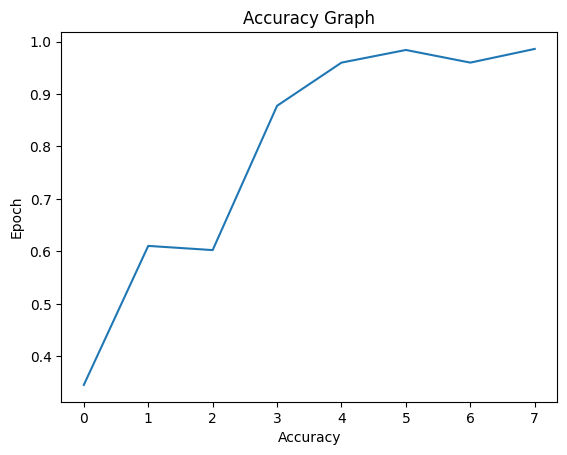

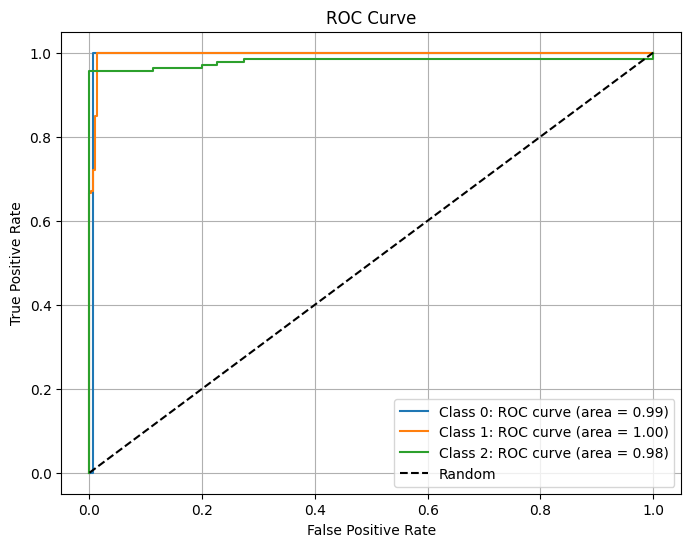

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       163
     Class 1       0.97      1.00      0.99       194
     Class 2       1.00      0.95      0.97       141

    accuracy                           0.99       498
   macro avg       0.99      0.98      0.99       498
weighted avg       0.99      0.99      0.99       498



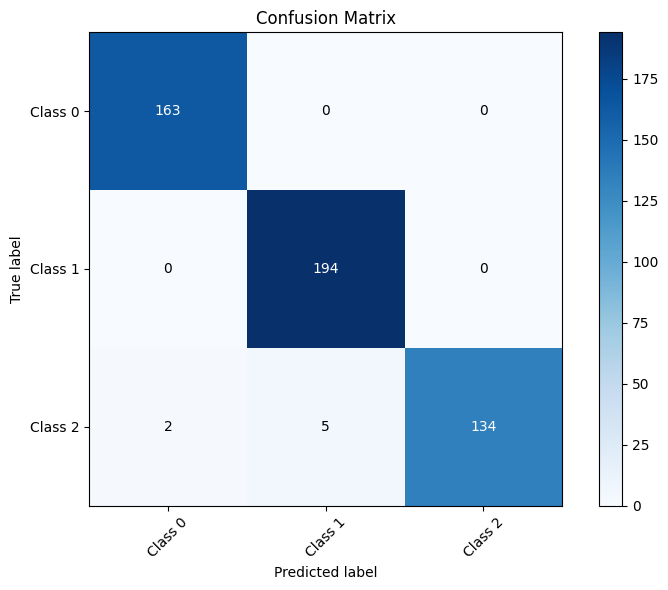

In [273]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have loaded your dataset into the 'data' DataFrame
# Separate features (X) and labels (y)
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the features for better training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define the layer sizes for the MLP
layer_sizes = [X_train.shape[1], 128, 128]  # Input layer size, hidden layer sizes, output layer size (3 classes)

# Create an instance of the MLP class
mlp = MLP(layer_sizes=layer_sizes, l2_lambda=0.01)

# Train the MLP
hist = mlp.fit(X_train, y_train, X_val, y_val, epochs=8, learning_rate=0.001, early_stopping_patience=10, dropout_prob=0.8)
import matplotlib.pyplot as plt
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.title("Accuracy Graph")
plt.plot(hist)
mlp.plot_roc_curve(X_val, y_val)
mlp.generate_classification_report(X_val, y_val)
mlp.generate_confusion_matrix(X_val, y_val)


In [274]:
import pickle

with open('brain_stroke-model-10.pkl', 'wb') as file:
    pickle.dump(mlp, file)

# Test Size = 20%

Epoch 1/8 - Loss: 4.8589 - Validation Accuracy: 0.3102
Epoch 2/8 - Loss: 3.5449 - Validation Accuracy: 0.6436
Epoch 3/8 - Loss: 2.3964 - Validation Accuracy: 0.6456
Epoch 4/8 - Loss: 1.5150 - Validation Accuracy: 0.8564
Epoch 5/8 - Loss: 0.7287 - Validation Accuracy: 0.9478
Epoch 6/8 - Loss: 0.3366 - Validation Accuracy: 0.9478
Epoch 7/8 - Loss: 0.2700 - Validation Accuracy: 0.9478
Epoch 8/8 - Loss: 0.2734 - Validation Accuracy: 0.9639
Training completed.
[7, 128, 128]


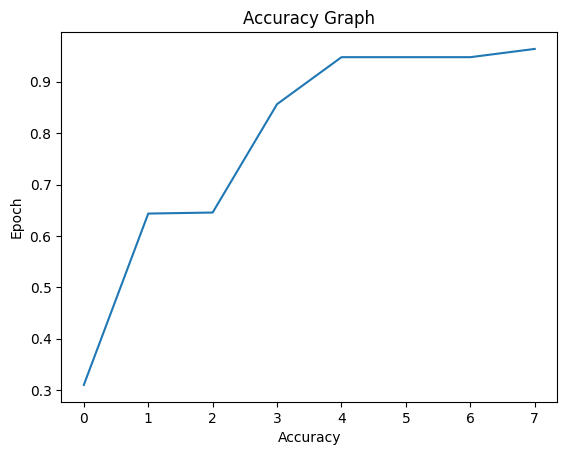

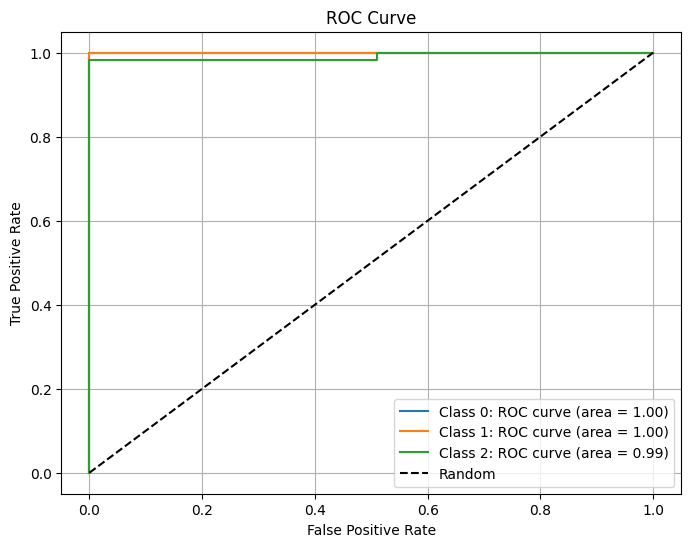

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       340
     Class 1       1.00      0.91      0.95       354
     Class 2       0.91      0.98      0.94       302

    accuracy                           0.96       996
   macro avg       0.96      0.97      0.96       996
weighted avg       0.97      0.96      0.96       996



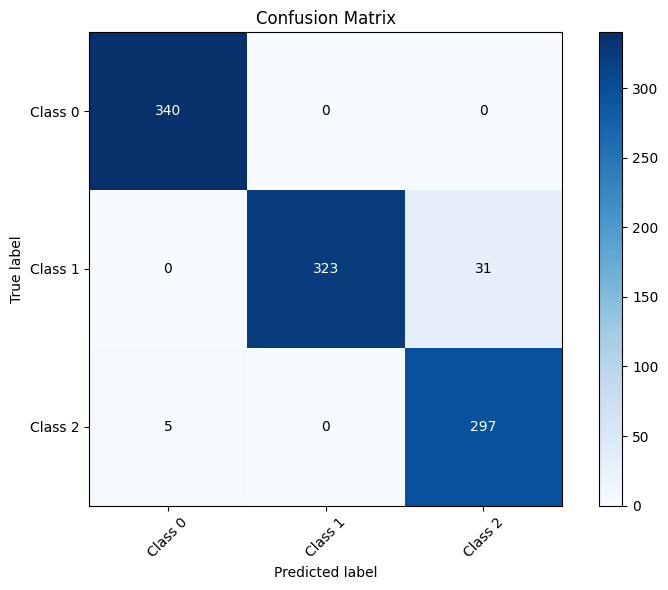

In [279]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have loaded your dataset into the 'data' DataFrame
# Separate features (X) and labels (y)
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define the layer sizes for the MLP
layer_sizes = [X_train.shape[1], 128, 128]  # Input layer size, hidden layer sizes, output layer size (3 classes)

# Create an instance of the MLP class
mlp = MLP(layer_sizes=layer_sizes, l2_lambda=0.01)

# Train the MLP
hist = mlp.fit(X_train, y_train, X_val, y_val, epochs=8, learning_rate=0.001, early_stopping_patience=10, dropout_prob=0.8)
import matplotlib.pyplot as plt
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.title("Accuracy Graph")
plt.plot(hist)
mlp.plot_roc_curve(X_val, y_val)
mlp.generate_classification_report(X_val, y_val)
mlp.generate_confusion_matrix(X_val, y_val)


In [280]:
import pickle

with open('brain_stroke-model-20.pkl', 'wb') as file:
    pickle.dump(mlp, file)

# Test Size = 30%

Epoch 1/8 - Loss: 4.8615 - Validation Accuracy: 0.3146
Epoch 2/8 - Loss: 3.7065 - Validation Accuracy: 0.4324
Epoch 3/8 - Loss: 2.6721 - Validation Accuracy: 0.4598
Epoch 4/8 - Loss: 1.8871 - Validation Accuracy: 0.6131
Epoch 5/8 - Loss: 1.2664 - Validation Accuracy: 0.9518
Epoch 6/8 - Loss: 0.6728 - Validation Accuracy: 0.9324
Epoch 7/8 - Loss: 0.3730 - Validation Accuracy: 0.9799
Epoch 8/8 - Loss: 0.3440 - Validation Accuracy: 0.9431
Training completed.
[7, 128, 128]


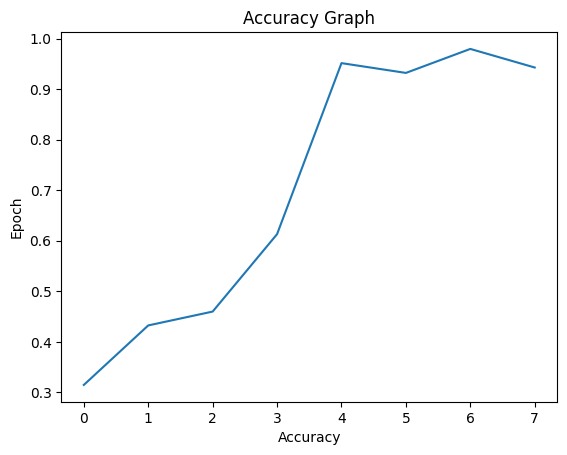

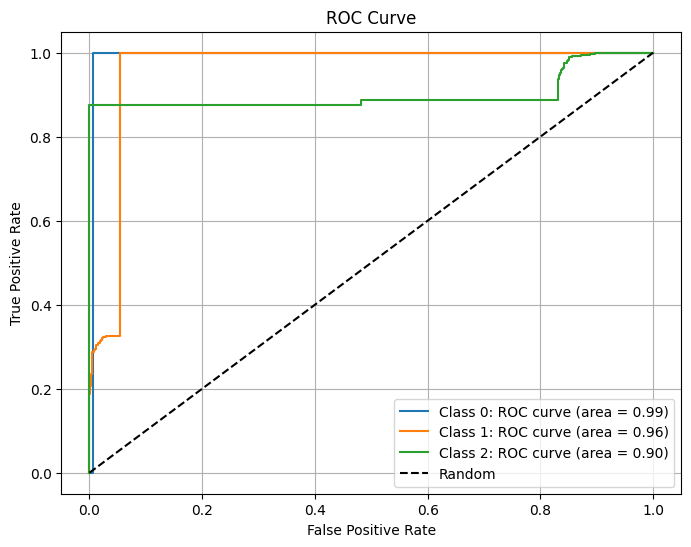

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99       493
     Class 1       0.88      1.00      0.94       531
     Class 2       1.00      0.82      0.90       470

    accuracy                           0.94      1494
   macro avg       0.95      0.94      0.94      1494
weighted avg       0.95      0.94      0.94      1494



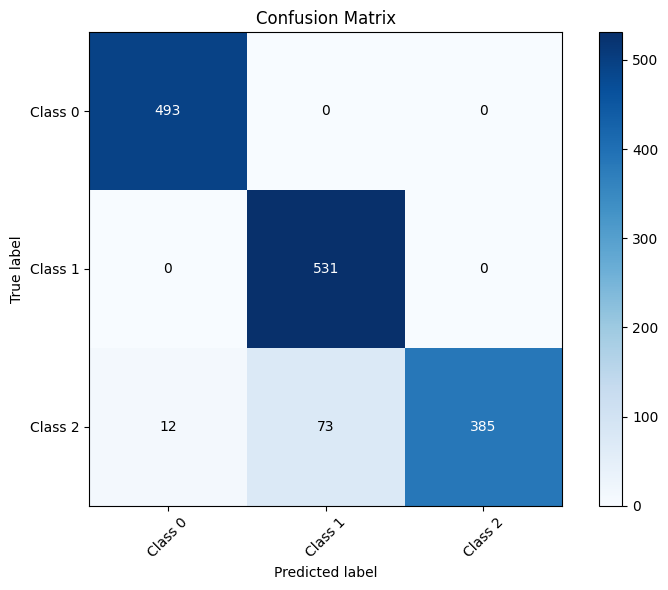

In [282]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have loaded your dataset into the 'data' DataFrame
# Separate features (X) and labels (y)
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features for better training
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Define the layer sizes for the MLP
layer_sizes = [X_train.shape[1], 128, 128]  # Input layer size, hidden layer sizes, output layer size (3 classes)

# Create an instance of the MLP class
mlp = MLP(layer_sizes=layer_sizes, l2_lambda=0.01)

# Train the MLP
hist = mlp.fit(X_train, y_train, X_val, y_val, epochs=8, learning_rate=0.001, early_stopping_patience=10, dropout_prob=0.8)
import matplotlib.pyplot as plt
plt.xlabel("Accuracy")
plt.ylabel("Epoch")
plt.title("Accuracy Graph")
plt.plot(hist)
mlp.plot_roc_curve(X_val, y_val)
mlp.generate_classification_report(X_val, y_val)
mlp.generate_confusion_matrix(X_val, y_val)

In [283]:
import pickle

with open('brain_stroke-model-30.pkl', 'wb') as file:
    pickle.dump(mlp, file)

# Export Scaler

In [199]:
with open('scaler-model.pkl', 'wb') as file:
    pickle.dump(scaler, file)